Average IVT of each AR object during El Nino, La Nina, AO+-, SH+-.


## Imports

In [15]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
import nclcmaps as nclc
from timeseries import persistence, select_months, create_list_all_dates
from teleconnections import build_teleconnection_df, mjo_index
from statistical_tests import xr_zscore_diff_mean
from ar_funcs import ar_daily_df

In [16]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [17]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

In [18]:
# choose season
ssn = 'djfmam'
ceofid = 'IVT'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

In [19]:
# import configuration file for dictionary choice
yaml_doc = '../data/plt_config.yml'

config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
#select dictionaries - choose var, anom/nanom, and season
# upper_ precip_ ivt_ and non_anom anom
plot_dict_upper = config['upper_diff']
# plot_dict_ivt = config['ivt_diff']
plot_dict_prec = config['precip_diff']
plot_dict_iwv = config['iwv_diff']
plot_dict_500 = config['lower_diff']

plot_dicts = [plot_dict_upper, plot_dict_500, plot_dict_iwv, plot_dict_prec]

# djf_dict mam_dict djfmam_dict
ar_dict = config[ssn]

### AR days and Climate Indices

In [20]:
outpath = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
start_date = '1979-12-01'
end_date = '2019-05-31'

# climate index df
tele = build_teleconnection_df('daily', 'COND', start_date, end_date)
mjo = mjo_index('daily', ar_dict['start_date'], ar_dict['end_date'])
tele['MJO'] = mjo['COND']
df_index = select_months(tele, 12, 5)

df = ar_daily_df(ssn, nk, outpath)
# combine ar df with tele df
# join indices with AR count
new_df = df.join(df_index)
new_df

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH,MJO
date,,,,,,,,,,
1979-12-01 09:00:00,0.0,1.0,0.0,1.0,2,1,0,0,0,1
1979-12-02 09:00:00,1.0,0.0,0.0,1.0,1,1,0,0,0,1
1979-12-03 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-04 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-05 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2019-05-27 09:00:00,0.0,0.0,0.0,0.0,0,0,0,1,1,1
2019-05-28 09:00:00,0.0,0.0,0.0,0.0,0,-1,0,1,1,1
2019-05-29 09:00:00,1.0,0.0,0.0,1.0,1,-1,0,1,1,1


### AR Catalog

In [21]:
# start-end dates
start_date = '1979-12-01 0:00'
end_date = '2019-05-31 18:00'

# Select lat/lon grid
lonmin = 0.
lonmax = 120
latmin = 0
latmax = 60

filename =  '/home/sbarc/students/nash/data/ar_catalog/globalARcatalog_ERA-Interim_1979-2019_v3.0.nc'
ds = xr.open_dataset(filename, engine='netcdf4')
ds = ds.squeeze()
da = ds.kidmap
# subset data
da = da.sel(time=slice(start_date, end_date), lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))
da = da.resample(time='1D').mean()
# da

In [22]:
fname = path_to_data + 'ERA5/ivt/anomalies/daily_filtered_anomalies_*.nc'

rename_dict = {'p71.162': 'ivte', 
               'p72.162': 'ivtn', 
               'latitude': 'lat',
               'longitude': 'lon'}

def preprocess(ds):
    '''rename vars'''
    subset = ds.rename(rename_dict)

    return subset

# open data  
dask.config.set(**{'array.slicing.split_large_chunks': False})
ds = xr.open_mfdataset(fname, preprocess=preprocess, combine='by_coords')

ivt_mag = np.sqrt(ds.ivte**2 + ds.ivtn**2)
ds = ds.assign(ivt=ivt_mag) # assign ivt

# regrid to 1.5 x 0.5 degree
ds= ds.interp(lon=da.lon, lat=da.lat)
# subset data
ds = ds.sel(time=slice(start_date, end_date), lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds

ds size in GB 1.15



<xarray.Dataset>
Dimensions:    (lat: 41, lon: 81, time: 14427)
Coordinates:
  * time       (time) datetime64[ns] 1979-12-01T09:00:00 ... 2019-05-31T09:00:00
    dayofyear  (time) int64 dask.array<chunksize=(31,), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 115.5 117.0 118.5 120.0
  * lat        (lat) float64 0.0 1.5 3.0 4.5 6.0 ... 54.0 55.5 57.0 58.5 60.0
    lev        float64 1e+03
    ens        float64 1.0
Data variables:
    ivtn       (time, lat, lon) float64 dask.array<chunksize=(31, 41, 81), meta=np.ndarray>
    ivte       (time, lat, lon) float64 dask.array<chunksize=(31, 41, 81), meta=np.ndarray>
    ivt        (time, lat, lon) float64 dask.array<chunksize=(31, 41, 81), meta=np.ndarray>

In [23]:
%%time
ds = ds.assign(kidmap=(['time', 'lat', 'lon'], da.values))
ds.load()

CPU times: user 1min 1s, sys: 1min 15s, total: 2min 16s
Wall time: 1min 11s


<xarray.Dataset>
Dimensions:    (lat: 41, lon: 81, time: 14427)
Coordinates:
  * time       (time) datetime64[ns] 1979-12-01T09:00:00 ... 2019-05-31T09:00:00
    dayofyear  (time) int64 335 336 337 338 339 340 ... 146 147 148 149 150 151
  * lon        (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 115.5 117.0 118.5 120.0
  * lat        (lat) float64 0.0 1.5 3.0 4.5 6.0 ... 54.0 55.5 57.0 58.5 60.0
    lev        float64 1e+03
    ens        float64 1.0
Data variables:
    ivtn       (time, lat, lon) float64 45.13 38.38 22.21 ... -34.6 -43.5 -59.75
    ivte       (time, lat, lon) float64 32.95 50.79 69.62 ... -45.1 -41.64
    ivt        (time, lat, lon) float64 55.88 63.66 73.07 ... 59.81 62.66 72.83
    kidmap     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [24]:
# average IVT using AR mask
ivt_mask = ds.ivt.where(ds.kidmap > 0).mean(['lat', 'lon'])
# ivt_mask = ivt_mask.resample(time="1D").mean('time')
# Select months
idx = (ivt_mask.time.dt.month >= 12) | (ivt_mask.time.dt.month <= 5)
ivt_mask = ivt_mask.sel(time=idx)

new_df['ivt'] = ivt_mask.values

idx = (new_df.AR_CAT > 0) 
plot_df = new_df.loc[idx]
plot_df

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH,MJO,ivt
date,,,,,,,,,,,
1979-12-01 09:00:00,0.0,1.0,0.0,1.0,2,1,0,0,0,1,118.984601
1979-12-02 09:00:00,1.0,0.0,0.0,1.0,1,1,0,0,0,1,121.362237
1979-12-08 09:00:00,0.0,1.0,0.0,1.0,2,1,0,0,0,1,114.264120
1979-12-09 09:00:00,1.0,0.0,0.0,1.0,1,1,0,0,0,1,116.455984
1979-12-16 09:00:00,1.0,0.0,0.0,1.0,1,-1,0,0,0,1,152.528085
...,...,...,...,...,...,...,...,...,...,...,...
2019-05-19 09:00:00,1.0,0.0,0.0,1.0,1,-1,0,1,1,1,158.027660
2019-05-21 09:00:00,1.0,0.0,0.0,1.0,1,-1,0,1,1,1,170.924148
2019-05-24 09:00:00,0.0,0.0,1.0,1.0,3,0,0,1,1,1,163.701591


/home/nash/DATA/repositories/AR_types/figs/IVT/djfmam/neof2/k3/boxplot.png


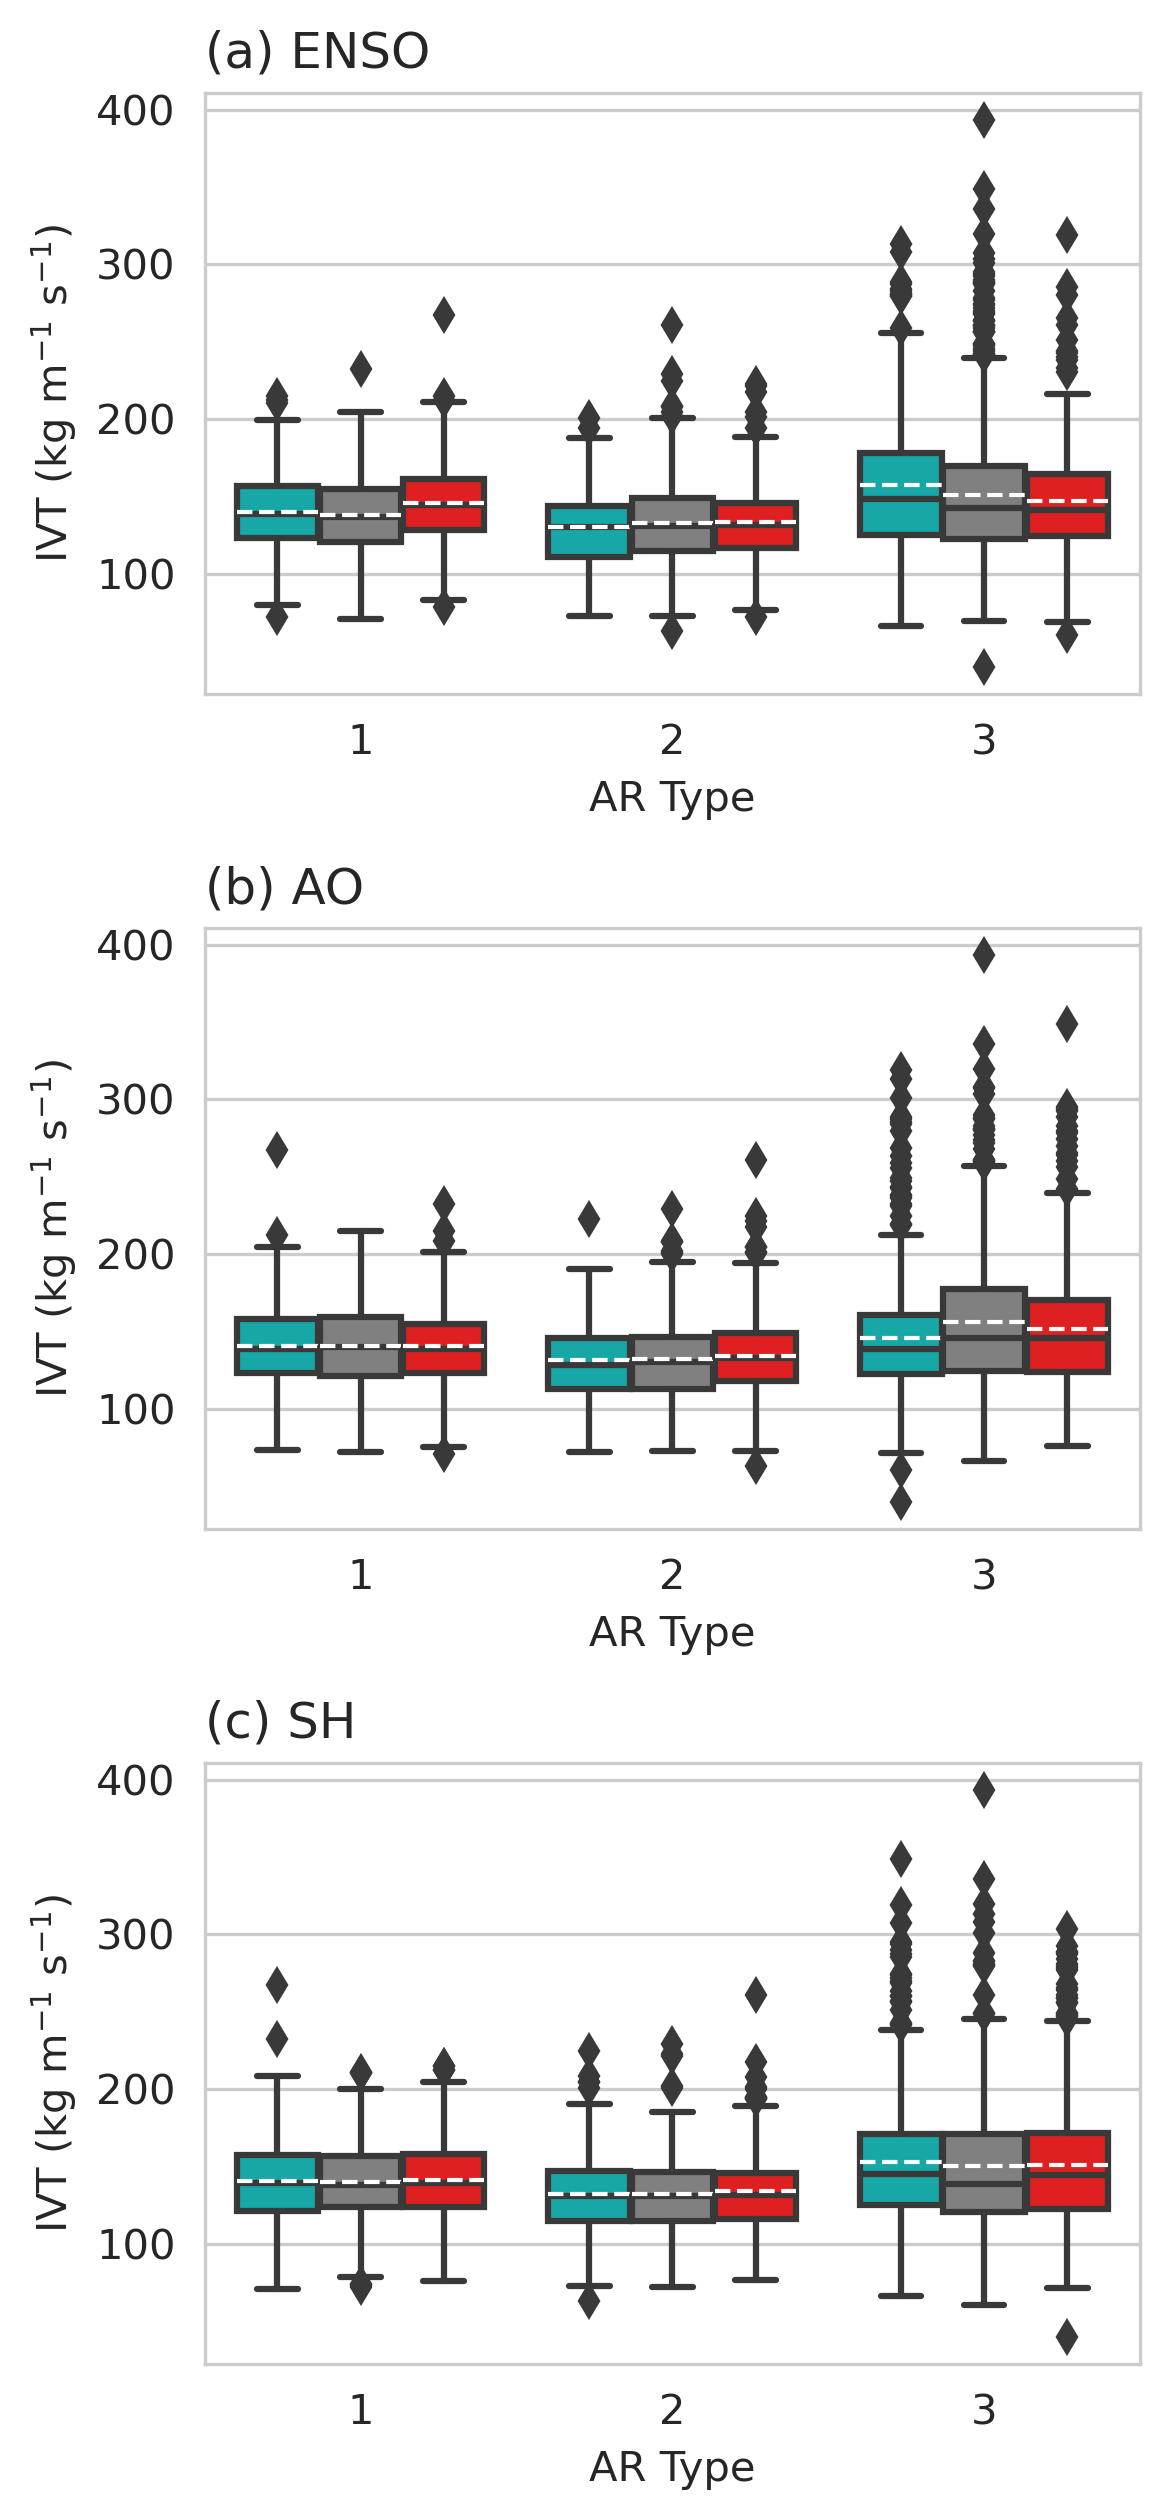

<Figure size 1200x2550 with 0 Axes>

In [25]:
fname = fig_path + 'boxplot'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((4.0,8.5))
fig.dpi = 300
nrows = 3
ncols = 1
nplots=nrows*ncols

plt_lbl = ['(a) ENSO', '(b) AO', '(c) SH']
cli_lst = ['ENSO', 'AO', 'SH']
flatui = ['c', 'grey', 'red', ]
sns.set_style("whitegrid")


for i, cli in enumerate(cli_lst):
    sns.set_style("whitegrid")
    data = plot_df
    ax = plt.subplot(nrows, ncols, i+1)

    g = sns.boxplot(x="AR_CAT", y="ivt", hue=cli, data=data, palette=flatui, 
                    meanline=True, showmeans=True, meanprops={'c':'white', 'lw':1})
    
    g.legend_.remove()
    sns.set_style("ticks")
    ax.set_ylabel('IVT (kg m$^{-1}$ s$^{-1}$)')
    ax.set_xlabel('AR Type')
#     plt.ylim(50, 150)
    ax.set_title(plt_lbl[i], loc='left')

# Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, labels=['Negative', 'Neutral', 'Positive'], title='Phase')
    

plt.tight_layout()
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

In [13]:
# average IVT using AR mask
ivt_mask = ds.ivt.mean(['lat', 'lon'])
# ivt_mask = ivt_mask.resample(time="1D").mean('time')
# Select months
idx = (ivt_mask.time.dt.month >= 12) | (ivt_mask.time.dt.month <= 5)
ivt_mask = ivt_mask.sel(time=idx)

new_df['ivt'] = ivt_mask.values

idx = (new_df.AR_CAT > 0) 
plot_df = new_df.loc[idx]
plot_df

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH,MJO,ivt
date,,,,,,,,,,,
1979-12-01 09:00:00,0.0,1.0,0.0,1.0,2,1,0,0,0,1,85.744980
1979-12-02 09:00:00,1.0,0.0,0.0,1.0,1,1,0,0,0,1,75.950645
1979-12-08 09:00:00,0.0,1.0,0.0,1.0,2,1,0,0,0,1,59.175622
1979-12-09 09:00:00,1.0,0.0,0.0,1.0,1,1,0,0,0,1,54.952170
1979-12-16 09:00:00,1.0,0.0,0.0,1.0,1,-1,0,0,0,1,59.244956
...,...,...,...,...,...,...,...,...,...,...,...
2019-05-19 09:00:00,1.0,0.0,0.0,1.0,1,-1,0,1,1,1,101.938546
2019-05-21 09:00:00,1.0,0.0,0.0,1.0,1,-1,0,1,1,1,109.676432
2019-05-24 09:00:00,0.0,0.0,1.0,1.0,3,0,0,1,1,1,97.794881


/home/nash/DATA/repositories/AR_types/figs/IVT/djfmam/neof2/k3/boxplot2.png


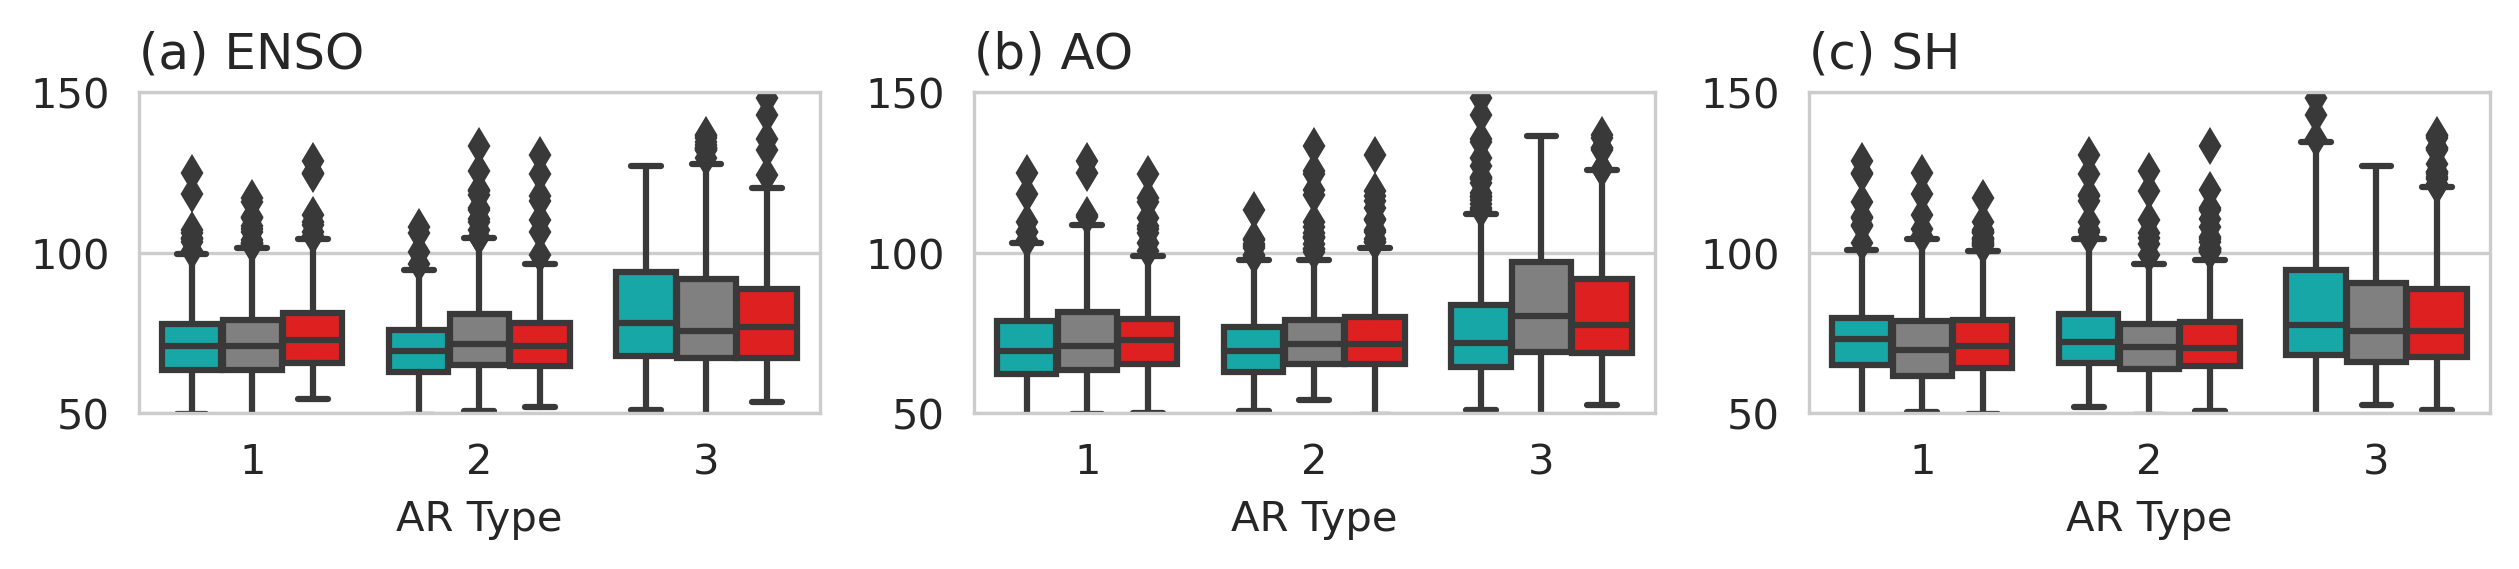

<Figure size 2550x600 with 0 Axes>

In [14]:
fname = fig_path + 'boxplot2'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((8.5,2.0))
fig.dpi = 300
nrows = 1
ncols = 3
nplots=nrows*ncols

plt_lbl = ['(a) ENSO', '(b) AO', '(c) SH']
cli_lst = ['ENSO', 'AO', 'SH']
flatui = ['c', 'grey', 'red', ]
sns.set_style("whitegrid")


for i, cli in enumerate(cli_lst):
    sns.set_style("whitegrid")
    data = plot_df
    ax = plt.subplot(nrows, ncols, i+1)

    g = sns.boxplot(x="AR_CAT", y="ivt", hue=cli, data=data, palette=flatui)
    
    g.legend_.remove()
    sns.set_style("ticks")
    ax.set_ylabel('')
    ax.set_xlabel('AR Type')
    plt.ylim(50, 150)
    ax.set_title(plt_lbl[i], loc='left')

# Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, labels=['Negative', 'Neutral', 'Positive'], title='Phase')
    

plt.tight_layout()
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

In [18]:
%%time
date_lst = new_df.index.strftime('%Y-%m-%d').values # list of days no time
final_lst = []
dates = []
ivt_lst = []
for i, ids in enumerate(date_lst):
    print(ids)
    # pull track ID list for each time step
    x = ds.kidmap.sel(time=ids, lat=slice(20, 40), lon=slice(65,95)).values.flatten()
    result = x[np.logical_not(np.isnan(x))]
    trackID = list(set(result.tolist()))
    final_lst.append(trackID)
    
    ivt_vals = []
    for j, tID in enumerate(trackID):
        dates.append(ids)
        ivt_mask = ds.sel(time=ids) # select the time step
        # get the mean IVT value for each trackID at that time step
        ivt_mean = ivt_mask.ivt.where(ivt_mask.kidmap == tID).mean().values
        ivt_vals.append(ivt_mean)
        print(tID, ivt_mean)
        
    ivt_lst.append(ivt_vals)


1979-12-01
2864.0 119.81571217891123
2861.0 115.65646421995343
1979-12-02
2864.0 111.39032539716274
2861.0 94.78335265856735
1979-12-03
2861.0 79.58414371195998
1979-12-04
1979-12-05
1979-12-06
1979-12-07
2886.6666666666665 110.5437255297592
2918.0 96.94599308361148
1979-12-08
2871.0 114.26411975905611
1979-12-09
2871.0 107.52485155497104
1979-12-10
1979-12-11
1979-12-12
1979-12-13
1979-12-14
1979-12-15
1979-12-16
2975.0 119.04788944856492
1979-12-17
2978.0 95.456042725172
2975.0 69.34932379964998
1979-12-18
1979-12-19
1979-12-20
1979-12-21
2988.0 123.72533402309641
1979-12-22
2988.0 116.2529185468376
1979-12-23
1979-12-24
3033.0 125.27550057661337
3029.5 172.50319793713206
1979-12-25
3033.0 114.80437235455183
1979-12-26
1979-12-27
3038.0 114.9642531345713
1979-12-28
3038.0 127.29586368890538
1979-12-29
1979-12-30
3065.0 148.6141401223955
1979-12-31
1980-01-01
1980-01-02
3096.0 124.13354772357123
1980-01-03
1980-01-04
1980-01-05
1980-01-06
1980-01-07
3137.0 89.76731393764689
1980-01-08

7051.0 107.27358052604244
1981-04-10
7051.0 102.89916964284305
1981-04-11
7051.0 110.64497322714833
1981-04-12
7051.0 90.1569013699741
1981-04-13
7051.0 94.47958946815699
1981-04-14
7051.0 87.26112513092225
1981-04-15
1981-04-16
1981-04-17
7114.0 114.50940239463854
1981-04-18
7114.0 112.5222705951809
7134.0 121.35153065602505
1981-04-19
7140.0 226.51154270196955
7142.0 103.16477531965057
1981-04-20
1981-04-21
1981-04-22
1981-04-23
1981-04-24
1981-04-25
1981-04-26
1981-04-27
1981-04-28
7205.0 113.03095346623238
1981-04-29
7212.0 123.56558966321316
1981-04-30
7223.0 162.9414084907356
1981-05-01
7232.0 130.86252324572095
7223.0 172.0720502882604
1981-05-02
7232.5 211.08931183443138
7242.0 160.2484388297381
7223.0 132.536841014851
1981-05-03
7247.0 120.80805545003209
1981-05-04
7258.0 154.7163834203916
1981-05-05
1981-05-06
1981-05-07
1981-05-08
1981-05-09
1981-05-10
1981-05-11
1981-05-12
1981-05-13
1981-05-14
7338.0 103.80412525001698
1981-05-15
1981-05-16
1981-05-17
7338.0 226.7055922370

12973.0 130.29711044316605
1983-03-07
12973.0 123.43237682292792
1983-03-08
12973.0 165.64515716563358
1983-03-09
13011.0 144.65502649995668
1983-03-10
13022.0 154.5394206149094
1983-03-11
1983-03-12
13034.0 153.57567902204858
1983-03-13
13057.0 141.13341240340264
13034.0 143.07013340423606
13060.0 100.50450461878367
13054.0 71.3921634815841
1983-03-14
13068.0 135.4373998145471
13063.0 149.722225740731
1983-03-15
13063.0 166.10108213373945
13065.5 128.10997671622832
13068.0 137.55921549940908
13070.25 125.22110163561815
13071.0 207.36327802242783
13072.5 169.4323721829096
1983-03-16
13082.0 180.0093688553251
13063.0 136.6557922735464
1983-03-17
1983-03-18
1983-03-19
13106.0 144.85851479685732
13101.0 188.10548224877576
1983-03-20
13101.0 155.93743469135978
1983-03-21
13101.0 117.76094713621231
13105.25 228.36841897175654
13106.666666666666 197.6127925917499
13109.5 149.9826121494242
13118.0 131.48936046292383
1983-03-22
13127.0 89.39493618057563
13101.0 201.1868759542295
13107.5 194.82

18714.0 142.65116788898752
1984-12-29
18713.0 118.13951094303005
1984-12-30
1984-12-31
18746.0 137.2248175554943
1985-01-01
18747.0 139.0130572247538
18748.5 267.320370998213
18750.0 106.5927973969218
1985-01-02
18741.0 141.3284354057489
18750.0 139.7122401894881
1985-01-03
18741.0 163.42670231157993
18750.0 128.24773537110914
1985-01-04
1985-01-05
1985-01-06
1985-01-07
1985-01-08
1985-01-09
1985-01-10
1985-01-11
18806.0 111.42174941294088
1985-01-12
18809.5 103.11605992088008
18833.0 89.5071227739097
1985-01-13
18786.0 149.65857541456734
1985-01-14
1985-01-15
1985-01-16
18863.0 88.12702242416265
1985-01-17
18875.0 183.90231426844318
18868.0 61.76934763545259
18871.5 71.2949817354663
1985-01-18
1985-01-19
18875.0 91.87052564549253
1985-01-20
1985-01-21
1985-01-22
18908.0 79.4555721662897
1985-01-23
1985-01-24
18924.0 80.07956813476363
1985-01-25
1985-01-26
1985-01-27
1985-01-28
1985-01-29
1985-01-30
1985-01-31
1985-02-01
1985-02-02
18980.0 83.85876694670611
18985.5 142.6323966493433
18

22781.0 131.42352379157674
1986-05-18
1986-05-19
22802.0 146.3164275341859
1986-05-20
1986-05-21
1986-05-22
22831.0 74.43492030879851
1986-05-23
1986-05-24
1986-05-25
1986-05-26
1986-05-27
1986-05-28
1986-05-29
22879.0 47.26874993912965
1986-05-30
1986-05-31
1986-12-01
24571.0 130.98892886558588
1986-12-02
24571.0 133.71934957959712
1986-12-03
24571.0 92.92918808689245
1986-12-04
24571.0 98.04674689213671
1986-12-05
24571.0 142.7718594201569
1986-12-06
24571.0 143.47467122740446
1986-12-07
24571.0 48.69554365377228
1986-12-08
1986-12-09
24638.0 66.24558856101311
1986-12-10
1986-12-11
24666.0 106.20186524811584
24668.0 149.41251919049373
24669.0 111.93324683075086
1986-12-12
24683.0 168.12303957523446
1986-12-13
24683.0 160.9394990942546
1986-12-14
24691.0 136.9028425260158
1986-12-15
1986-12-16
1986-12-17
24716.0 110.11983644608755
1986-12-18
24733.0 121.80036703687598
1986-12-19
1986-12-20
24738.0 127.66796534578279
1986-12-21
24738.0 71.65628312675751
1986-12-22
1986-12-23
1986-12-24

28409.0 62.95734810247884
28426.5 67.26119634402497
28444.0 122.22472379503755
28420.666666666668 157.31858979389088
1988-03-13
28444.0 188.33305103720434
1988-03-14
28444.0 185.23411907373335
1988-03-15
28467.0 133.0489971207019
28463.0 86.63652151733305
1988-03-16
28471.0 39.29624126658791
1988-03-17
1988-03-18
28494.0 100.19948161875439
1988-03-19
28494.0 95.81954388850598
1988-03-20
28494.0 120.352345755198
1988-03-21
28437.0 88.28256326547547
1988-03-22
1988-03-23
28524.0 93.37775427559401
1988-03-24
28524.0 131.84797591917314
1988-03-25
28524.0 134.1620915759087
1988-03-26
1988-03-27
1988-03-28
28572.0 44.666937824309336
1988-03-29
1988-03-30
1988-03-31
1988-04-01
28597.0 79.15354564547765
1988-04-02
1988-04-03
1988-04-04
1988-04-05
1988-04-06
1988-04-07
1988-04-08
1988-04-09
1988-04-10
1988-04-11
1988-04-12
1988-04-13
1988-04-14
1988-04-15
1988-04-16
1988-04-17
28667.0 104.75239691100244
1988-04-18
28667.0 61.37788118959124
1988-04-19
1988-04-20
1988-04-21
28747.0 105.7068878382

34284.0 159.29242663396207
1990-01-20
34336.0 142.54202856617604
34338.0 163.68911702367666
34340.0 62.31943046729344
1990-01-21
1990-01-22
1990-01-23
1990-01-24
1990-01-25
34384.0 90.27128259476186
34385.333333333336 56.33997098639602
34386.0 54.44651080338625
1990-01-26
34384.0 106.95186949321705
1990-01-27
34384.0 98.84852809443804
1990-01-28
34412.0 107.76762790091165
1990-01-29
34426.0 82.53476278405957
34412.0 86.29679185186814
1990-01-30
34436.0 96.93341298759876
1990-01-31
1990-02-01
1990-02-02
1990-02-03
34444.0 117.59401379427335
1990-02-04
34467.0 111.67498970195922
1990-02-05
34467.0 128.68326228830955
1990-02-06
34467.0 142.77803306821053
1990-02-07
34467.0 110.8997717074965
1990-02-08
34500.0 103.03600581709621
1990-02-09
1990-02-10
34507.0 151.6317372670621
1990-02-11
34507.0 149.1293207314467
1990-02-12
34507.0 156.3359023598531
1990-02-13
34533.0 180.48754810021344
1990-02-14
1990-02-15
34542.0 118.24378839446878
1990-02-16
34542.0 128.97862886744375
1990-02-17
1990-02

38050.0 73.07216799209944
1991-04-08
1991-04-09
38066.0 22.475607458202102
1991-04-10
38070.0 160.17747615357138
1991-04-11
38077.0 58.94049882548534
38078.0 161.7086461587239
1991-04-12
1991-04-13
38102.0 204.3057721706433
1991-04-14
38108.0 51.660629652295036
1991-04-15
1991-04-16
38125.0 161.53646626058978
1991-04-17
1991-04-18
1991-04-19
1991-04-20
1991-04-21
1991-04-22
1991-04-23
1991-04-24
1991-04-25
1991-04-26
1991-04-27
38215.0 149.9885071003922
1991-04-28
1991-04-29
38231.0 439.03743112822366
1991-04-30
38225.666666666664 233.40602137707313
38227.0 355.35249392016954
38215.0 196.27022799308398
38231.0 123.9080914419656
1991-05-01
38215.0 201.49854569182787
1991-05-02
38251.0 152.36941151684272
1991-05-03
38251.0 117.66071322698113
1991-05-04
38266.0 108.44228473619306
38251.0 161.72384895591722
1991-05-05
38266.0 148.61681386153774
38268.5 152.06218614920272
38271.0 129.43786114842527
1991-05-06
38275.0 145.48678379146563
38277.0 153.9349357908412
1991-05-07
1991-05-08
38290.0

43450.0 55.71363930425636
1992-12-25
1992-12-26
1992-12-27
43504.0 113.17907279067904
1992-12-28
43514.0 78.95960445165714
43509.0 144.9568096366341
1992-12-29
43518.0 148.14449750332545
1992-12-30
43518.0 144.06857399401287
1992-12-31
43518.0 135.64133015390843
1993-01-01
1993-01-02
1993-01-03
1993-01-04
43557.0 160.9294132388192
1993-01-05
43569.0 157.93766730695685
1993-01-06
43569.0 175.37105298841914
1993-01-07
43575.0 171.0091226431624
1993-01-08
43575.0 165.08376254224657
1993-01-09
43595.0 188.270422693384
43575.0 121.64512867262737
1993-01-10
43575.0 103.90555265512778
1993-01-11
43611.0 96.16727574418466
1993-01-12
43617.0 149.04285572928947
1993-01-13
43624.666666666664 184.39615878481268
43617.0 126.11663918124667
43628.5 146.87055869085313
1993-01-14
43644.0 147.58263832092283
1993-01-15
43644.0 133.92131296384753
1993-01-16
43644.0 91.6913978484528
1993-01-17
1993-01-18
1993-01-19
1993-01-20
1993-01-21
1993-01-22
1993-01-23
1993-01-24
43717.0 108.08805545856664
1993-01-25

47128.0 137.19153449532487
1994-03-20
1994-03-21
47146.0 134.46565207960415
1994-03-22
1994-03-23
47167.0 111.15195665085592
1994-03-24
47177.0 90.18813683581529
1994-03-25
47190.0 109.9627467537352
1994-03-26
47204.0 96.46996386533955
1994-03-27
47208.0 160.2399985260637
47190.0 111.93978113709292
1994-03-28
47190.0 86.31690074759751
1994-03-29
47190.0 81.16163129833323
1994-03-30
1994-03-31
1994-04-01
47251.0 196.51343119942482
47239.0 94.24742113053728
1994-04-02
47242.0 89.9216615342247
1994-04-03
47242.0 104.12355346713262
1994-04-04
47242.0 139.20368320053427
1994-04-05
47242.0 90.59671872268869
1994-04-06
1994-04-07
1994-04-08
47302.0 78.68175145967385
1994-04-09
1994-04-10
47313.0 52.16020392216559
1994-04-11
1994-04-12
1994-04-13
1994-04-14
1994-04-15
47350.0 89.60872098659132
1994-04-16
47360.0 66.4599204715174
1994-04-17
47368.0 117.26043767035156
1994-04-18
47376.0 177.78340221446769
1994-04-19
47376.0 204.5819322831149
1994-04-20
1994-04-21
1994-04-22
1994-04-23
47424.0 12

52782.0 123.51196335913095
1996-01-13
52792.0 129.50405257259357
52787.0 149.17879855806288
52788.666666666664 139.59262679081962
52782.0 82.73508871790389
1996-01-14
52799.0 126.62480022242315
1996-01-15
52799.0 130.58580404739777
1996-01-16
52816.0 71.81694641542491
1996-01-17
1996-01-18
1996-01-19
1996-01-20
1996-01-21
1996-01-22
52870.0 109.7621357783857
1996-01-23
52878.0 113.48930401803223
1996-01-24
52878.0 132.02261131368516
1996-01-25
1996-01-26
1996-01-27
1996-01-28
1996-01-29
1996-01-30
1996-01-31
1996-02-01
1996-02-02
52957.0 107.4578693735668
1996-02-03
52957.0 80.66015332593723
1996-02-04
1996-02-05
52994.0 101.78301607610548
1996-02-06
52994.0 87.10453812467325
1996-02-07
1996-02-08
1996-02-09
53027.0 191.07209297166122
1996-02-10
53023.0 109.17769010618912
53039.0 149.7214594496458
1996-02-11
53023.0 99.08939303111934
1996-02-12
53053.0 60.85937526064661
1996-02-13
1996-02-14
53066.0 90.45319047226474
1996-02-15
1996-02-16
1996-02-17
1996-02-18
1996-02-19
1996-02-20
199

56523.0 160.61016654769958
1997-04-06
56552.0 148.83784776840693
56523.0 121.05184531790194
1997-04-07
56557.0 92.53038185500213
1997-04-08
1997-04-09
56579.0 78.54376526544706
56582.0 114.54585276745136
1997-04-10
56579.0 104.23781444298605
1997-04-11
56579.0 120.75402742976479
1997-04-12
1997-04-13
1997-04-14
1997-04-15
1997-04-16
1997-04-17
1997-04-18
1997-04-19
56654.0 77.65730532193493
1997-04-20
1997-04-21
1997-04-22
1997-04-23
1997-04-24
1997-04-25
1997-04-26
56707.0 136.10113189341308
56709.0 163.0117916656466
56711.0 107.83391362784243
1997-04-27
56717.0 134.75830323563622
1997-04-28
1997-04-29
1997-04-30
1997-05-01
1997-05-02
1997-05-03
56768.0 140.21004152649834
1997-05-04
1997-05-05
56776.0 193.66981473154158
1997-05-06
56776.0 174.16570026561863
1997-05-07
56800.0 102.75324344408567
1997-05-08
56807.0 71.4447022283542
1997-05-09
56816.0 134.93074017176397
1997-05-10
1997-05-11
1997-05-12
56846.0 117.99972757866811
1997-05-13
1997-05-14
56849.0 91.247946260507
1997-05-15
19

61910.0 71.29447100435833
1998-12-15
1998-12-16
1998-12-17
1998-12-18
1998-12-19
1998-12-20
1998-12-21
1998-12-22
1998-12-23
1998-12-24
61970.0 89.65554470079093
1998-12-25
61970.0 76.71935510620342
1998-12-26
1998-12-27
1998-12-28
1998-12-29
1998-12-30
1998-12-31
62011.0 103.45946241719977
1999-01-01
62011.0 91.7624768603915
1999-01-02
62011.0 65.3002481051425
1999-01-03
1999-01-04
1999-01-05
1999-01-06
62082.0 124.79713568615776
1999-01-07
62082.0 79.32128356468517
62091.0 82.49669795625081
1999-01-08
1999-01-09
1999-01-10
62106.0 87.57623855177528
1999-01-11
1999-01-12
62120.0 87.80821013805439
1999-01-13
1999-01-14
1999-01-15
1999-01-16
1999-01-17
1999-01-18
1999-01-19
62158.0 126.68580463075354
1999-01-20
62162.0 173.55298130981114
62170.0 103.85041955318826
62164.0 125.72713700664949
62158.0 81.4681831049076
1999-01-21
62170.0 57.66956506177483
1999-01-22
1999-01-23
1999-01-24
1999-01-25
1999-01-26
1999-01-27
1999-01-28
1999-01-29
62224.0 131.4347836262246
1999-01-30
1999-01-31
1

66266.0 82.60301404139518
2000-05-13
2000-05-14
2000-05-15
2000-05-16
2000-05-17
2000-05-18
2000-05-19
2000-05-20
66323.0 114.3736350127265
2000-05-21
66337.0 137.29461877459525
2000-05-22
2000-05-23
66352.0 193.82925516004798
2000-05-24
66352.0 177.04125041230301
2000-05-25
66352.0 214.80419539293536
2000-05-26
66368.66666666667 80.13477104051705
66377.0 83.52836040276229
66352.0 234.03059657073686
66360.33333333333 271.4082145578127
66364.5 159.7927156288275
66366.0 223.78905944387523
2000-05-27
66384.33333333333 223.9011307013554
66377.0 147.5761745065365
66388.0 89.793994926029
66382.5 206.63878124482537
2000-05-28
66394.0 181.72035068045923
66397.0 169.7235449451604
2000-05-29
66400.0 118.07521543891366
66404.0 64.65983375091845
2000-05-30
66409.0 130.63055575006004
2000-05-31
66409.0 113.28085007808318
66421.0 45.80160857245141
2000-12-01
68002.0 72.33707003823453
68015.0 106.58092633418816
2000-12-02
68002.0 66.2956068793561
2000-12-03
2000-12-04
68032.0 61.754751976521796
2000-

72219.0 138.29586427412363
2002-04-05
72225.0 126.33699237065629
72210.0 150.902898418292
72214.5 100.57279059344954
72216.0 112.63063324744644
72219.0 85.55206934512934
72222.0 114.25954884547149
2002-04-06
72210.0 88.88704053687486
2002-04-07
2002-04-08
2002-04-09
72256.5 130.19872576908608
72258.0 86.71977739387177
72255.0 40.98016148980668
2002-04-10
2002-04-11
72254.0 167.9782084122789
2002-04-12
72254.0 142.4436403246329
2002-04-13
72254.0 118.62967898910057
2002-04-14
72281.0 161.38368126439883
72254.0 121.19884426325524
2002-04-15
72293.0 110.25332593027025
72254.0 67.88976887300639
2002-04-16
2002-04-17
2002-04-18
72216.0 103.44535384461899
72313.0 98.05468684297739
2002-04-19
72216.0 101.40310737945055
72313.0 187.13951839088304
2002-04-20
72317.0 111.54920342021505
2002-04-21
72322.66666666667 143.42687307266354
72325.5 156.95077374450776
72328.33333333333 156.30282660304658
72334.0 98.97714897372518
72317.0 79.53081993335176
2002-04-22
72334.0 87.37814862833146
2002-04-23
2

77809.0 122.79678395154505
2004-01-10
77848.66666666667 91.90845135528225
77850.0 78.59546202997545
77846.0 113.53046568191309
77854.0 66.84008283575824
2004-01-11
77850.0 65.66577498310365
77846.0 139.159690290541
77854.0 76.63064978123158
2004-01-12
77846.0 126.67426036650541
2004-01-13
77846.0 127.5208672858925
2004-01-14
77846.0 115.38828431002433
2004-01-15
77846.0 106.93886533555856
2004-01-16
77894.0 63.252274095982656
2004-01-17
2004-01-18
2004-01-19
2004-01-20
77935.0 152.04709072881533
2004-01-21
77935.0 128.6628475433511
2004-01-22
77935.0 133.0557388439462
2004-01-23
77935.0 124.91479801899355
2004-01-24
77962.0 76.63244054408632
77948.5 140.15606123798662
77935.0 71.3616904867793
2004-01-25
2004-01-26
77974.0 91.56505591104141
2004-01-27
77979.0 92.63763751904013
2004-01-28
2004-01-29
2004-01-30
78012.0 93.14410598097592
2004-01-31
78023.0 101.54409116597122
2004-02-01
2004-02-02
78037.0 116.9968246368482
2004-02-03
78046.0 154.31309225540744
2004-02-04
2004-02-05
2004-02-

81563.0 133.71660680242218
2005-03-01
81563.0 208.88808360975938
2005-03-02
81563.0 163.84113625886005
2005-03-03
2005-03-04
2005-03-05
81612.0 125.34945944931643
2005-03-06
81617.0 131.75024389538277
2005-03-07
81630.0 166.4860210240339
2005-03-08
81637.0 166.6119076739033
2005-03-09
81657.0 133.40446549370515
81644.0 139.91230499492363
2005-03-10
81644.0 147.30446286036022
2005-03-11
81644.0 136.20987528764837
2005-03-12
81644.0 124.05057433852474
2005-03-13
81644.0 96.06066872143354
2005-03-14
81698.0 99.65300015504992
2005-03-15
81698.0 92.20777509779171
2005-03-16
81714.0 92.08742259147199
2005-03-17
81714.0 94.14429241485396
2005-03-18
81729.0 80.13056578350981
2005-03-19
81735.0 109.62317728381636
2005-03-20
81745.0 105.92709669866402
81735.0 119.95453367236355
2005-03-21
81745.0 123.67704411434514
2005-03-22
2005-03-23
81774.0 135.76622623615157
2005-03-24
81776.0 101.97565621884198
81774.0 147.38962312886417
2005-03-25
81776.0 99.11172634383716
81779.33333333333 88.40173500148

87984.0 185.36380342127978
2007-02-11
87984.0 112.18904226426478
87994.0 144.58739914244566
88014.0 73.07985421567201
87999.0 111.77337457232997
2007-02-12
88026.0 102.72181963701846
2007-02-13
88031.0 151.60341536869464
2007-02-14
88038.0 139.12287785785242
2007-02-15
88038.0 175.18166254704064
2007-02-16
2007-02-17
2007-02-18
2007-02-19
88074.0 81.9840112062808
2007-02-20
88074.0 101.78789491284641
2007-02-21
2007-02-22
2007-02-23
2007-02-24
2007-02-25
88130.0 103.00559123988482
2007-02-26
88130.0 71.94908735626859
88132.66666666667 81.79914912074682
88134.0 77.8882854054192
88135.33333333333 97.99414880409431
88138.0 76.21756331976364
2007-02-27
88138.0 114.63416350621387
2007-02-28
88138.0 93.3295147620075
2007-03-01
88165.0 72.67512417552466
2007-03-02
88165.0 101.58475390814586
2007-03-03
2007-03-04
2007-03-05
2007-03-06
2007-03-07
2007-03-08
2007-03-09
2007-03-10
2007-03-11
88247.0 143.75388546777089
2007-03-12
88247.0 150.6681225417198
2007-03-13
88263.0 103.49966485960148
2007

94008.0 199.8400420342894
2008-12-20
94008.0 87.5912719142503
2008-12-21
2008-12-22
94036.0 132.38276990110427
2008-12-23
94036.0 112.80886302195802
2008-12-24
94036.0 103.62340647458772
2008-12-25
2008-12-26
94068.0 139.94007314776908
2008-12-27
2008-12-28
2008-12-29
2008-12-30
2008-12-31
2009-01-01
94101.0 117.43879311918975
2009-01-02
94101.0 110.87694159942522
2009-01-03
94101.0 105.17701031959713
2009-01-04
2009-01-05
2009-01-06
2009-01-07
2009-01-08
2009-01-09
2009-01-10
2009-01-11
2009-01-12
2009-01-13
2009-01-14
2009-01-15
94213.0 156.90278264672946
94214.0 205.31159212387084
94215.0 127.41894726329151
2009-01-16
94215.0 140.25612101147476
2009-01-17
2009-01-18
2009-01-19
2009-01-20
2009-01-21
94265.0 124.27331886979782
2009-01-22
94265.0 151.40592494815078
2009-01-23
94280.0 111.90309381446002
2009-01-24
94280.0 101.77693577138113
94294.0 111.82996482162322
94287.0 178.9411508683558
2009-01-25
94294.0 105.10664241452814
2009-01-26
2009-01-27
2009-01-28
2009-01-29
2009-01-30
20

98343.0 106.39374323081255
2010-04-15
98343.0 144.18370487962014
2010-04-16
2010-04-17
98349.0 105.81706243343139
2010-04-18
98370.0 110.46891623848548
98371.0 67.82206811241663
2010-04-19
98379.0 106.79711556729296
2010-04-20
98379.0 136.7418674693862
98390.0 158.19084606937403
2010-04-21
98385.0 180.01178920852297
98379.0 142.4441508212144
98388.0 57.4159525779569
98397.0 30.275054938838895
2010-04-22
2010-04-23
98414.0 101.56501352077227
2010-04-24
98414.0 78.27627588889342
2010-04-25
98414.0 103.86245826407288
2010-04-26
2010-04-27
2010-04-28
2010-04-29
2010-04-30
98454.0 123.39449384990532
2010-05-01
98467.0 94.58648425010564
98460.5 146.61731329439684
98454.0 130.71174343230962
2010-05-02
98479.0 73.07094171460203
2010-05-03
98454.0 137.94958876234395
98479.0 137.60677761562442
2010-05-04
98466.5 69.62872672486746
98475.33333333333 167.64811541762623
98479.0 148.32978137546993
98486.0 86.2744360543882
98493.0 126.3108105317249
2010-05-05
98501.0 124.50964709091261
98479.0 115.658

104486.0 56.06864508767227
2012-02-10
2012-02-11
104491.0 173.70970939186196
2012-02-12
2012-02-13
2012-02-14
2012-02-15
2012-02-16
104547.0 78.74586176648587
2012-02-17
104555.0 143.48287282166572
2012-02-18
104555.0 115.84541607127575
2012-02-19
104555.0 136.42640526983456
2012-02-20
104555.0 165.853159099461
2012-02-21
2012-02-22
2012-02-23
2012-02-24
2012-02-25
2012-02-26
104625.0 118.63113416096758
2012-02-27
2012-02-28
2012-02-29
104650.0 78.92437049014679
2012-03-01
2012-03-02
104671.0 103.33033791389983
2012-03-03
104674.0 191.03952443154137
104675.0 85.63678891254327
2012-03-04
104675.0 98.82558055397337
2012-03-05
104675.0 76.08272340062555
2012-03-06
2012-03-07
2012-03-08
2012-03-09
2012-03-10
2012-03-11
2012-03-12
2012-03-13
104754.0 71.7031396353417
2012-03-14
104761.0 96.2743252945
104766.0 103.45022285440098
2012-03-15
104766.0 110.38605667448077
2012-03-16
104785.5 102.8534121490654
104789.0 84.82598424095985
104782.0 98.32004369606493
2012-03-17
104791.0 60.88275037545

108637.0 126.03712328359086
2013-05-31
108637.0 109.84241679796664
2013-12-01
110470.0 93.5693495334316
2013-12-02
2013-12-03
2013-12-04
110502.0 120.5633248082943
2013-12-05
110502.0 77.00841288452777
2013-12-06
110513.0 91.65695719841354
2013-12-07
2013-12-08
2013-12-09
2013-12-10
110567.0 66.24053604419633
2013-12-11
110575.0 188.24489729766398
2013-12-12
2013-12-13
2013-12-14
110587.0 103.77191449127154
2013-12-15
110587.0 105.79079226854174
2013-12-16
110587.0 84.67226080669016
2013-12-17
2013-12-18
2013-12-19
2013-12-20
2013-12-21
2013-12-22
2013-12-23
2013-12-24
2013-12-25
2013-12-26
2013-12-27
2013-12-28
2013-12-29
2013-12-30
2013-12-31
110754.0 102.57962263318304
2014-01-01
2014-01-02
2014-01-03
2014-01-04
2014-01-05
2014-01-06
2014-01-07
110810.0 117.23181179346456
2014-01-08
2014-01-09
2014-01-10
2014-01-11
2014-01-12
110852.5 124.36827602617379
110855.0 107.786835343065
2014-01-13
2014-01-14
110867.0 70.16993511895811
2014-01-15
110883.0 67.33655166338373
2014-01-16
2014-01

114998.5 28.46360211391371
115003.0 19.177774931180583
2015-04-04
115008.0 36.83030075533898
114985.0 101.8981154501899
114962.0 183.57481562583754
2015-04-05
115021.0 78.25004552365964
2015-04-06
115032.0 89.28642596631347
2015-04-07
2015-04-08
2015-04-09
2015-04-10
2015-04-11
2015-04-12
2015-04-13
115070.0 106.24714909903956
2015-04-14
115102.0 111.25369316508703
2015-04-15
115105.5 82.17884158379265
115106.66666666667 95.4470493283235
115109.0 107.40496331165171
2015-04-16
115117.0 63.299162812657585
2015-04-17
115107.0 157.39819364909772
115117.0 99.1657075630859
2015-04-18
115117.0 196.435176084485
2015-04-19
115147.0 97.80899647718626
115117.0 175.73625822611066
2015-04-20
115152.0 45.41878465032694
2015-04-21
2015-04-22
115166.0 120.21564428984361
2015-04-23
2015-04-24
2015-04-25
115180.0 110.44130674799054
2015-04-26
115180.0 113.1986981425166
2015-04-27
2015-04-28
2015-04-29
2015-04-30
2015-05-01
2015-05-02
2015-05-03
2015-05-04
2015-05-05
2015-05-06
2015-05-07
2015-05-08
1153

118750.0 572.7756077102931
2016-05-21
118766.0 391.4507012755258
2016-05-22
118766.0 303.60248186672203
2016-05-23
118766.0 335.46283667081747
2016-05-24
118778.5 37.488827667113014
118766.0 350.82454952375156
118791.0 49.250503973689526
2016-05-25
118784.0 119.97587837374411
118792.5 224.96715135681094
118801.0 101.84975206167503
118772.0 149.9078628015277
118775.0 126.49992831122483
118779.25 223.88587920107597
118783.66666666667 78.04347728594425
2016-05-26
118805.0 131.65271763417363
2016-05-27
2016-05-28
2016-05-29
118840.0 92.39299022070513
118836.0 24.447602665679735
118838.0 51.441648402710086
2016-05-30
118840.0 99.47696951493154
2016-05-31
118840.66666666667 168.6991414757344
118812.0 102.46669049929768
118855.0 62.4378380720664
2016-12-01
2016-12-02
120719.0 126.90433508284161
2016-12-03
120719.0 111.30940668305445
2016-12-04
120719.0 75.81845644267808
2016-12-05
120759.0 86.48379238668585
2016-12-06
120759.0 85.02915334526668
2016-12-07
120777.0 74.63091308160267
120771.0 1

124877.0 86.43216785244914
2018-03-10
124877.0 120.86595524093973
2018-03-11
124877.0 100.29953018588904
2018-03-12
124927.0 63.137840524787414
2018-03-13
124936.0 58.293893573134845
2018-03-14
2018-03-15
124954.0 173.43751855241777
2018-03-16
124954.0 139.15366686069328
2018-03-17
124954.0 140.68878634278838
2018-03-18
2018-03-19
2018-03-20
2018-03-21
2018-03-22
125013.0 89.5767336309259
2018-03-23
2018-03-24
2018-03-25
125017.0 144.69837773152832
2018-03-26
2018-03-27
2018-03-28
125052.5 107.01542243532003
125046.0 128.40339779095672
2018-03-29
125059.0 70.90642864820919
125052.5 130.3175864843939
125046.0 134.67901905772783
2018-03-30
125046.0 126.06300718781078
2018-03-31
125046.0 121.80760505736639
2018-04-01
2018-04-02
2018-04-03
2018-04-04
2018-04-05
2018-04-06
125116.0 74.36214037375436
2018-04-07
125122.0 100.15366026400969
2018-04-08
2018-04-09
2018-04-10
2018-04-11
2018-04-12
2018-04-13
125175.0 60.146533134826676
2018-04-14
125179.0 88.04906082313259
2018-04-15
125179.0 106

In [19]:
ivt_lst[0]

[array(119.81571218), array(115.65646422)]

In [20]:
ids = 1
ivt_mask = ds.ivt.isel(time=ids).where(ds.kidmap > 0)

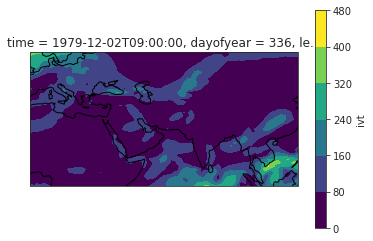

In [21]:
ax = plt.axes(projection=ccrs.PlateCarree())
ds.ivt.isel(time=ids).plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

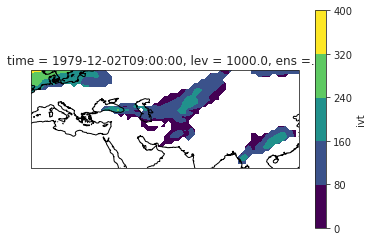

In [22]:
ax = plt.axes(projection=ccrs.PlateCarree())
ivt_mask.isel(time=ids).plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

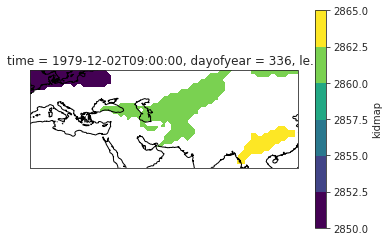

In [23]:
ax = plt.axes(projection=ccrs.PlateCarree())
ds.kidmap.isel(time=ids).plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()